In [ ]:
!pip install supervision
!pip install jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME) #путь для удобства

HOME: /content


In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data #загрузка данных для тестировки модели

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


#Использование SAM для сегментации

In [ ]:
import torch
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import supervision as sv
from google.colab.patches import cv2_imshow

In [ ]:
# Загрузка модели SAM
model_type = "vit_h"  # Выбираем модель (vit_b, vit_l, vit_h - разные варианты)
checkpoint_path = HOME+"/weights/"+"sam_vit_h_4b8939.pth"  # Путь к предобученному checkpoint файлу

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Загружаем модель
sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)

In [ ]:
# Создание генератора масок
mask_generator = SamAutomaticMaskGenerator(sam)

# Загрузка изображения
image_path = "/content/data/dog.jpeg"  # Замените на путь к вашему изображению
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Генерация масок
masks = mask_generator.generate(image_rgb)

# Вывод результатов
print(f"Количество сгенерированных масок: {len(masks)}")

Количество сгенерированных масок: 64


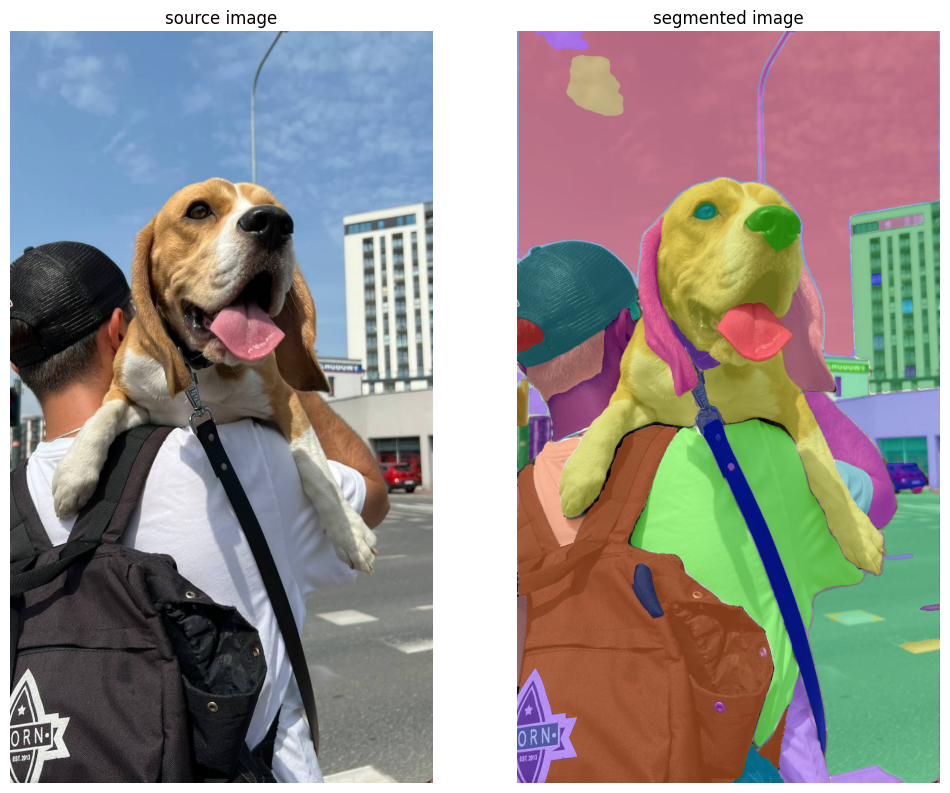

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image("/content/data/dog.jpeg")
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
import numpy as np


box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv
mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread("/content/data/dog.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

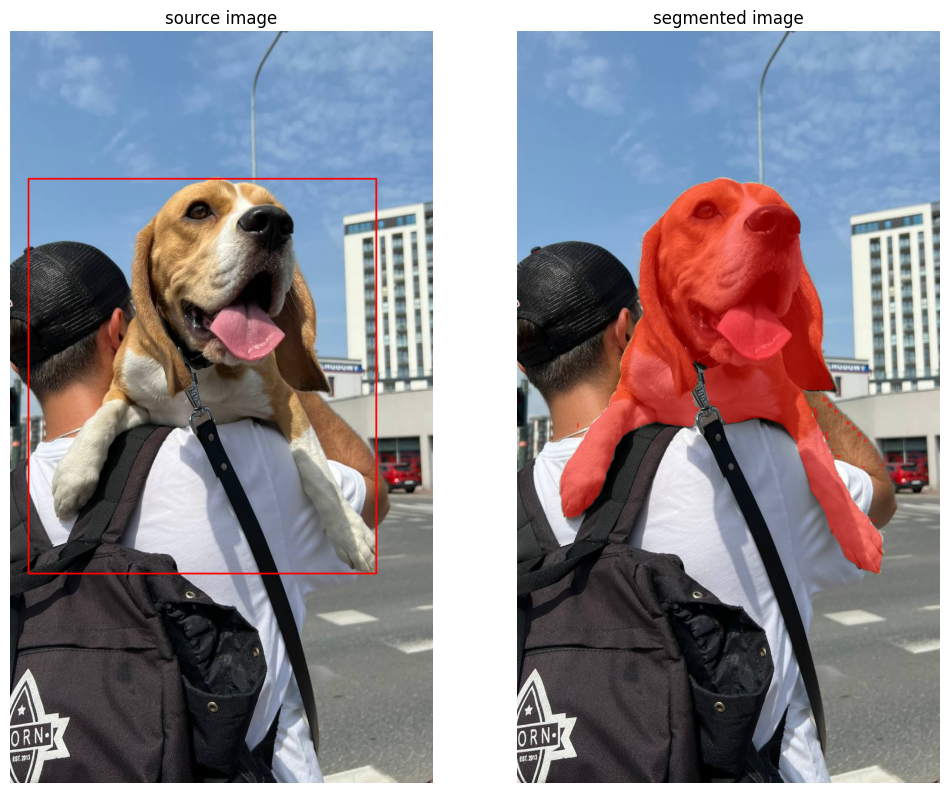

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

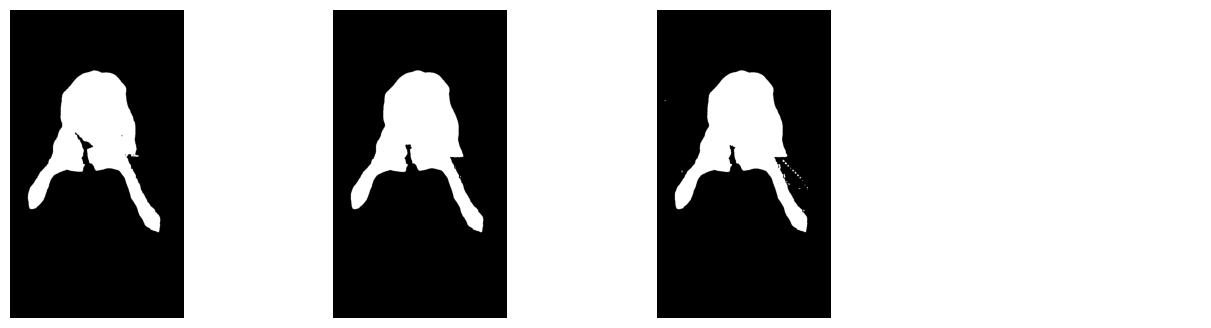

In [ ]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [ ]:
masks[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
import numpy as np
from PIL import Image


# Конвертация массива в объект изображения
img = Image.fromarray(masks[0])

# Сохранение изображения
img.save('output_image.png')

# Отображение изображения
img.show()

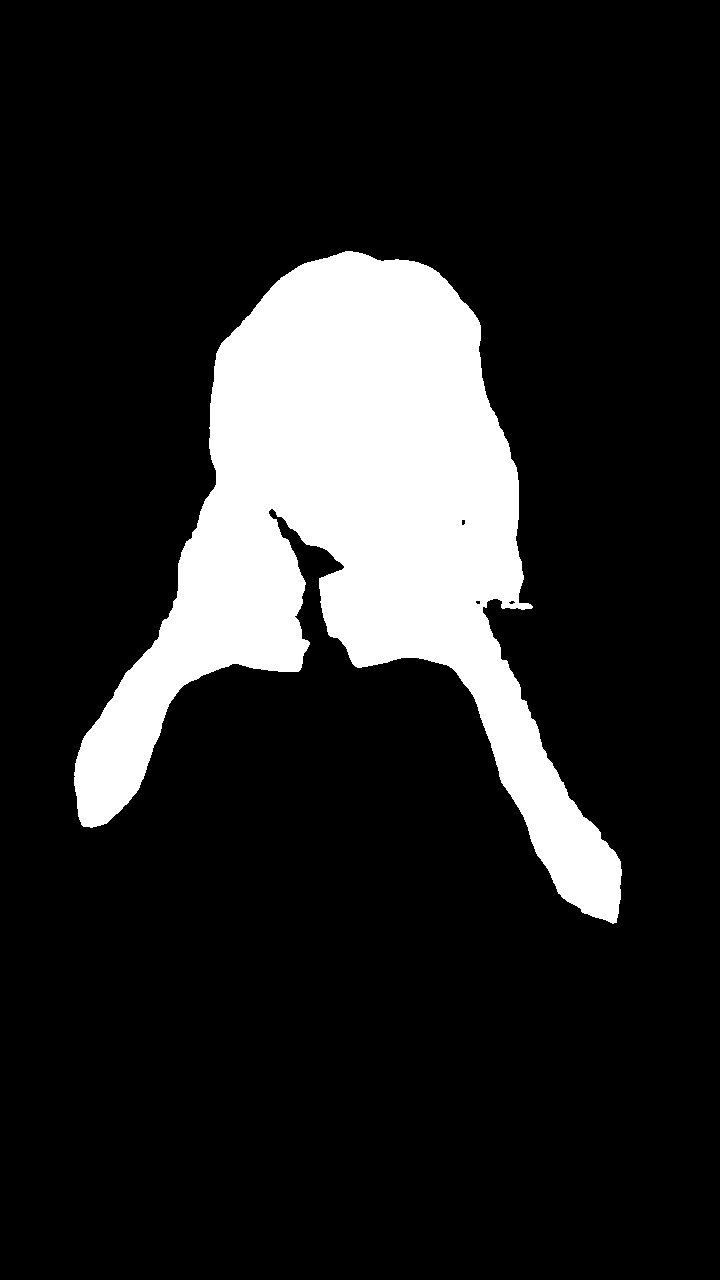

In [ ]:
img

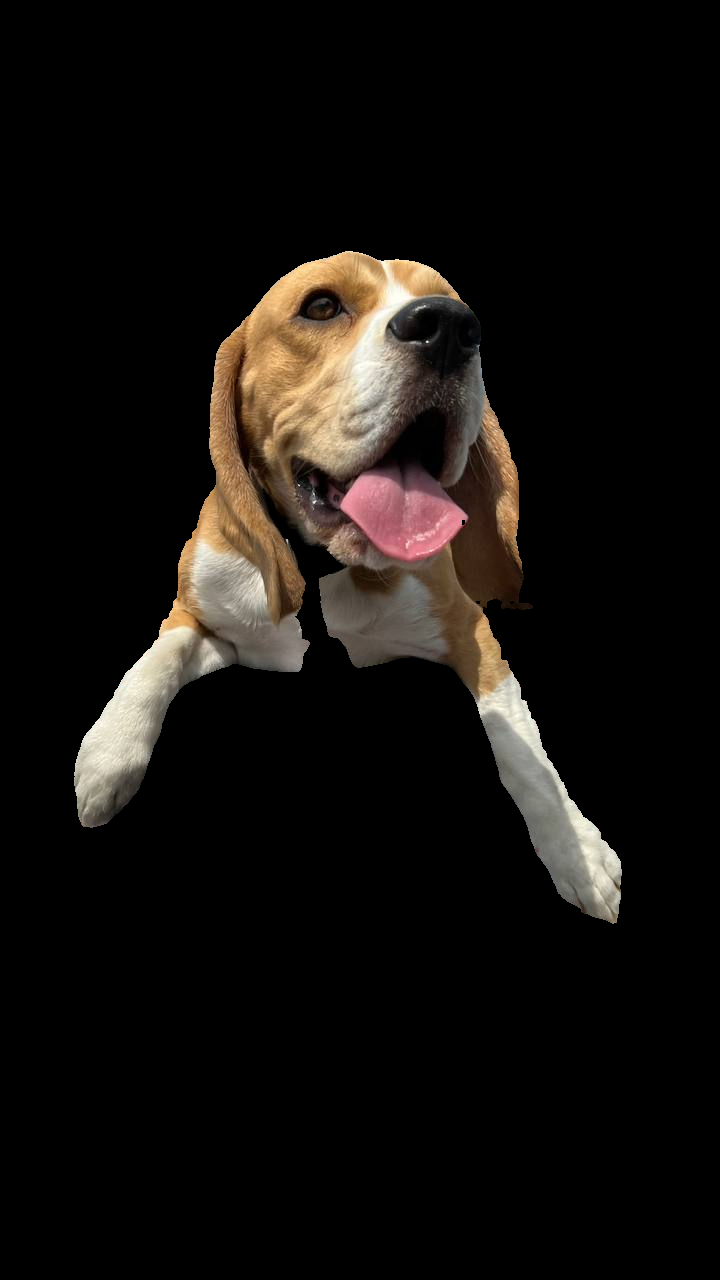

In [ ]:
import cv2
import numpy as np

def overlay_image_on_stencil(background_path, overlay_path):
    """
    Накладывает изображение на черно-белый трафарет.

    :param background_path: Путь к черно-белому изображению с трафаретом.
    :param overlay_path: Путь к изображению, которое будет наложено.
    :return: Изображение с наложенным трафаретом.
    """

    # Загрузка изображений
    background = cv2.imread(background_path)
    overlay = cv2.imread(overlay_path)

    # Проверка загрузки изображений
    if background is None or overlay is None:
        raise ValueError("Не удалось загрузить одно из изображений. Проверьте пути.")

    # Преобразование фона в градации серого
    gray_background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

    # Создание маски из трафарета (белые области)
    _, mask = cv2.threshold(gray_background, 240, 255, cv2.THRESH_BINARY)

    # Убедитесь, что размеры наложенного изображения совпадают с размерами маски
    if overlay.shape[0] != mask.shape[0] or overlay.shape[1] != mask.shape[1]:
        overlay = cv2.resize(overlay, (mask.shape[1], mask.shape[0]))

    # Наложение изображения на маску
    for c in range(0, 3):  # Для каждого цветового канала
        background[:, :, c] = np.where(mask == 255, overlay[:, :, c], background[:, :, c])

    return background

# Пример использования функции
if __name__ == "__main__":
    result_image = overlay_image_on_stencil('/content/output_image.png', '/content/data/dog.jpeg')

    # Сохранение и отображение результата
    cv2.imwrite('result_image.png', result_image)
    cv2_imshow(result_image)

    # Ожидание нажатия клавиши
    cv2.waitKey(0)

    # Закрытие всех окон
    cv2.destroyAllWindows()

#Использование базового клипа

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


image = Image.open("/content/result_image.png")

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = Image.open("/content/result_image.png")

inputs = processor(text=["лошадь", "кошка", "собака"], images=image, return_tensors="pt", padding=True)#задаем описание классов

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

In [ ]:
probs

tensor([[0.2500, 0.0213, 0.7287]], grad_fn=<SoftmaxBackward0>)

In [ ]:
np.argmax(probs.detach().numpy())#индекс предсказанного класса

2

#Использование модели, которая классифицирует ищет обьет по названию и сегментирует

In [ ]:
import requests
from PIL import Image
import torch

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

image = Image.open('/content/data/dog.jpeg')
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxs=[]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    boxs.append([round(i, 2) for i in box.tolist()])
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Detected a photo of a dog with confidence 0.624 at location tensor([ 62.3424, 238.6345, 641.2897, 902.7406])
Detected a photo of a dog with confidence 0.133 at location tensor([  53.0208,  256.5910,  644.4001, 1291.3276])


In [ ]:
boxs[0]

[62.34, 238.63, 641.29, 902.74]

#Построение bbox на картинке

In [ ]:
import cv2

def draw_bounding_box(image_path, output_path, left, top, width, height, label):
    """
    Рисует bounding box на изображении и сохраняет результат.

    :param image_path: Путь к исходному изображению.
    :param output_path: Путь для сохранения изображения с bounding box.
    :param left: Координата X верхнего левого угла.
    :param top: Координата Y верхнего левого угла.
    :param width: Ширина bounding box.
    :param height: Высота bounding box.
    :param label: Метка для bounding box.
    """

    image = cv2.imread(image_path)


    right = left + width
    bottom = top + height


    color = (0, 255, 0)
    thickness = 2


    cv2.rectangle(image, (left, top), (right, bottom), color, thickness)

    cv2.putText(image, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

    cv2.imwrite(output_path, image)

if __name__ == "__main__":
    coordinates = [62.34, 238.63, 641.29, 902.74]

    left = int(coordinates[0])
    top = int(coordinates[1])
    right = int(coordinates[2])
    bottom = int(coordinates[3])

    width = right - left
    height = bottom - top

    draw_bounding_box(
        image_path='/content/data/dog.jpeg',   # Путь к вашему изображению
        output_path='output_image.jpg',  # Путь для сохранения результата
        left=left,
        top=top,
        width=width,
        height=height,
        label='Object'                   # Класс обьекта
    )

In [ ]:
img=Image.open("/content/output_image.jpg")
img.show()

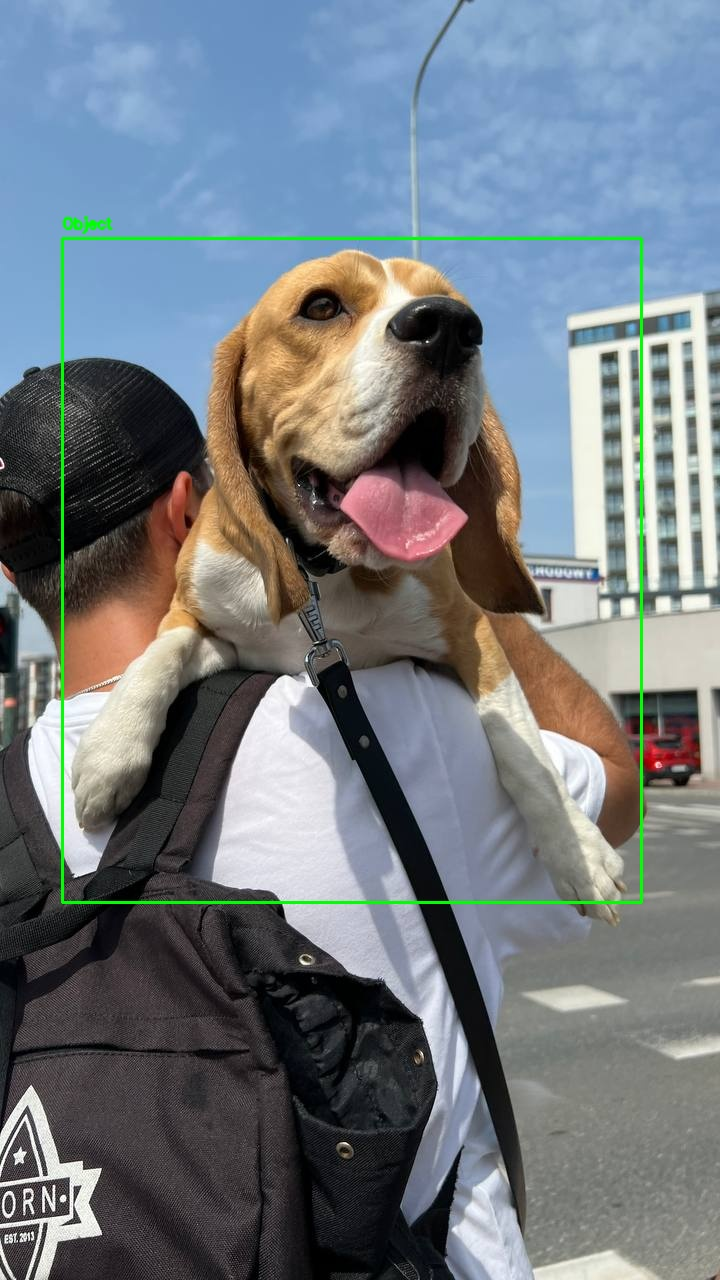

In [ ]:
img

#Использование прошлой модели и sam для сегментации, детекции и классификации

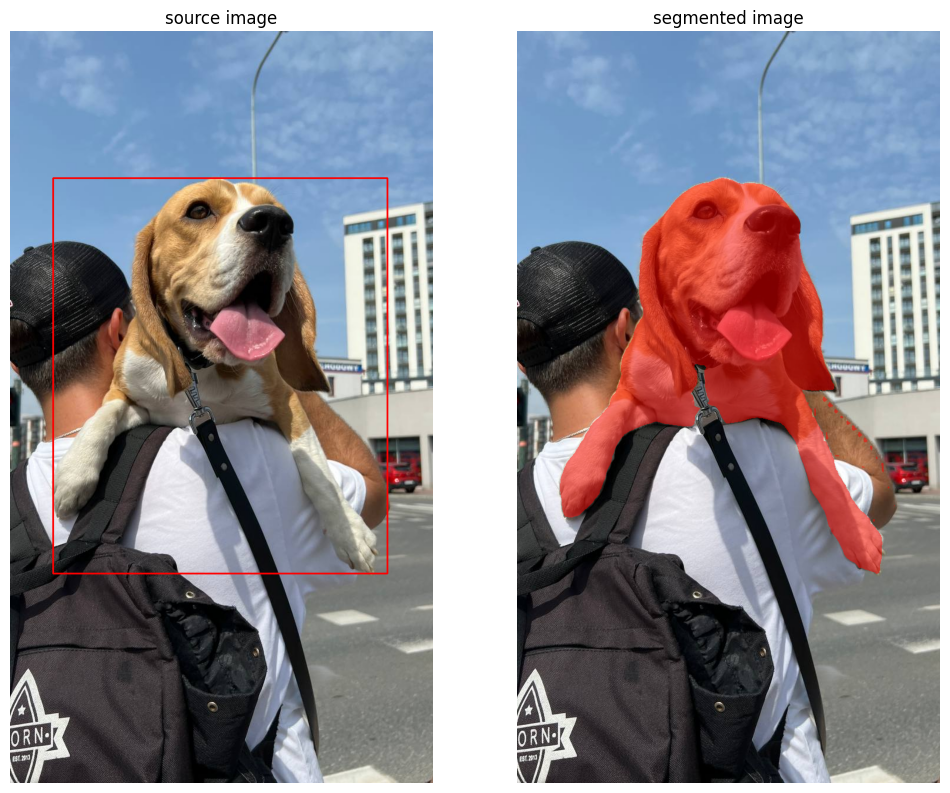

Класс: a photo of a dog


In [ ]:
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

image = Image.open('/content/data/dog.jpeg')
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0
text = texts[i]
boxs=[]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    boxs.append([round(i, 2) for i in box.tolist()])#


box = np.array([
    boxs[0][0],
    boxs[0][1],
    boxs[0][2],
    boxs[0][3]
])

mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread("/content/data/dog.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
print(f"Класс: {text[label.item()]}")